In [2]:
import os, dotenv, sys
from pathlib import Path

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from annotations.object_detection.object_detection import ImageForObjectDetection, Rect
from annotations.object_detection.dataset import DatasetForObjectDetection
from annotations import db
from bacili_detection.src.dataset.preprocessing import mask_filter, tile_coords
from bacili_detection.detr.util.misc import collate_fn

dotenv.load_dotenv('.env')
session = db.get_session(os.environ.get("DATABASE_URI"))
sys.path.append('bacili_detection/src')

Let's see how pretrained DETR works on a regular image. It should do well since it's an image form the COCO dataset, from which DETR was trained on.

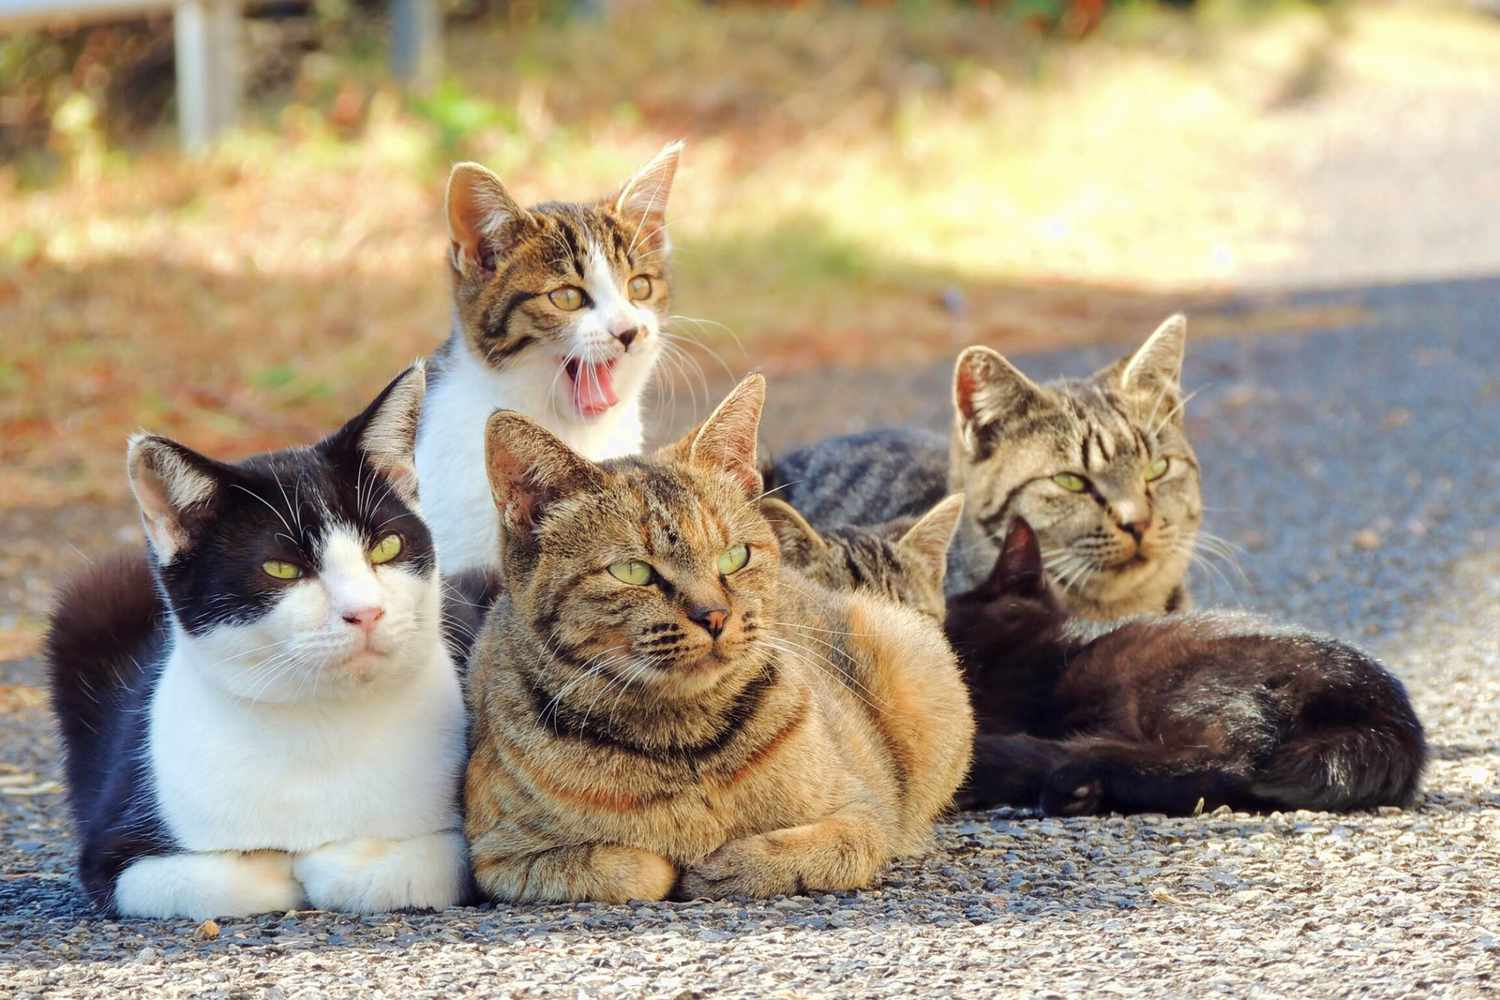

In [8]:
cat_image = ImageForObjectDetection(uri='data/other/cats.jpg')
cat_image.pil()

In [1]:
from huggingface_hub import hf_hub_download
from torchvision import transforms as T
import json


# load the COCO class labels
repo_id = "huggingface/label-files"
filename = "coco-detection-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label[91] = "other-object"
id2label = {int(k):v for k,v in id2label.items()}
# standard PyTorch mean-std input image normalization.
transform = T.Compose([  # These are necessary for inference with DETR
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Using cache found in /Users/simon/.cache/torch/hub/facebookresearch_detr_main


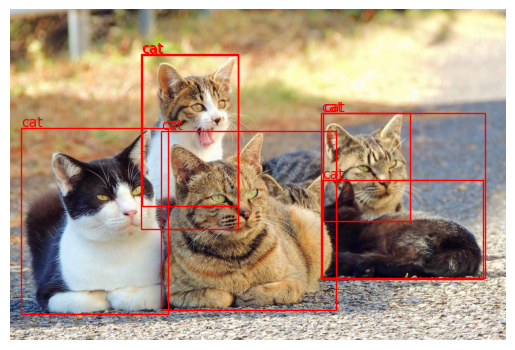

In [11]:
# run inference in the image
from bacili_detection.detr.models import detr_inference
# load the model
model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True)
model.eval(); # set model to evaluation mode (no training, only inference)

# plot the image with the predicted boxes
bboxes, labels = detr_inference([cat_image.pil().convert("RGB")], model, transform, id2label)
plt.imshow(cat_image.numpy())
for label, (x1, y1, x2, y2) in zip(labels[0],bboxes[0]):
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='r'))
    plt.text(x1, y1-5, label, color='r')
plt.axis('off');

That looks good! Let's see how it does on our own images.

----

Let's create define our dataset of near-sputum microscopy images with our own annotations

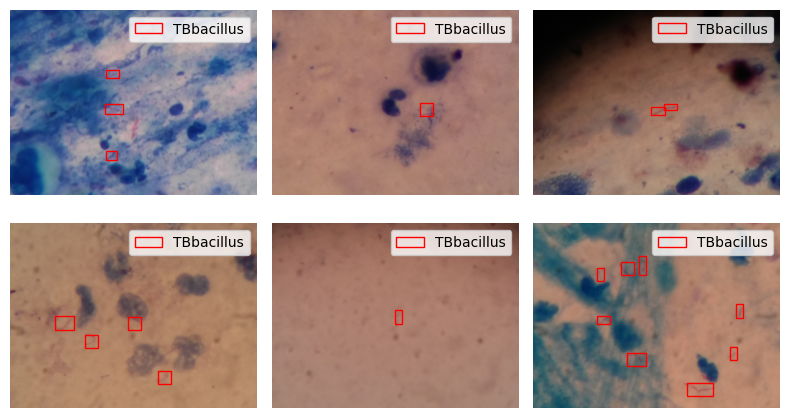

In [3]:
from bacili_detection.detr.datasets.tb_bacillus import TBBacilliDataset, make_ds_transforms
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch

dataset = TBBacilliDataset(
    ['train', 'val'], # sets to load
    transform=make_ds_transforms('val'),
    train=False,
)
# show some of the images in the dataset with their annotations
dataset.display(nrows=2, ncols=3, figsize=(8,6))

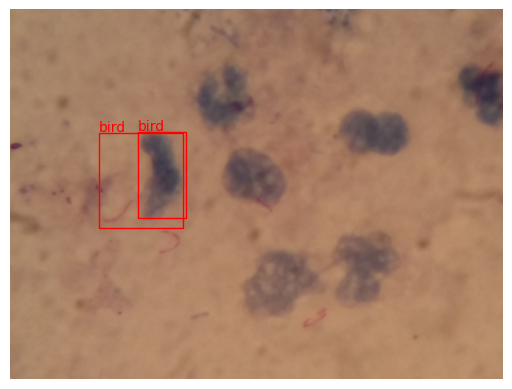

In [6]:
# lets try detr inference on the dataset
img = dataset._images[3].pil()
bboxes, labels = detr_inference(img, model, transform, id2label, threshold=0.5)
plt.imshow(img)
for label, (x1, y1, x2, y2) in zip(labels,bboxes[0]):
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='r'))
    plt.text(x1, y1-5, label, color='r')
plt.axis('off');

Yep, birds! That's not really what we are going for... 
Obviously DETR is not trained on our dataset, so it doesn't know what to look for.

Let's see how much can we improve this by finetuning it on this dataset.

In [12]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights (since we have only 1 class)
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'bacili_detection/detr/detr-r50_no-class-head.pth')

Let's check our datasets and dataloaders to get a better feel for what we are working with.

In [7]:
tr_dataset = dataset.subset('train')
eval_dataset = dataset.subset('val')

# now, create the dataloaders    
tr_dataloader = DataLoader(tr_dataset, batch_size=2, shuffle=True, collate_fn=lambda batch: list(zip(*batch)))
eval_dataloader = DataLoader(eval_dataset, batch_size=2, shuffle=False, collate_fn=lambda batch: list(zip(*batch)))

Show some output examples of the dataloader for fun. Remember! These are our ground truth bounding boxes, not the ones predicted by DETR.

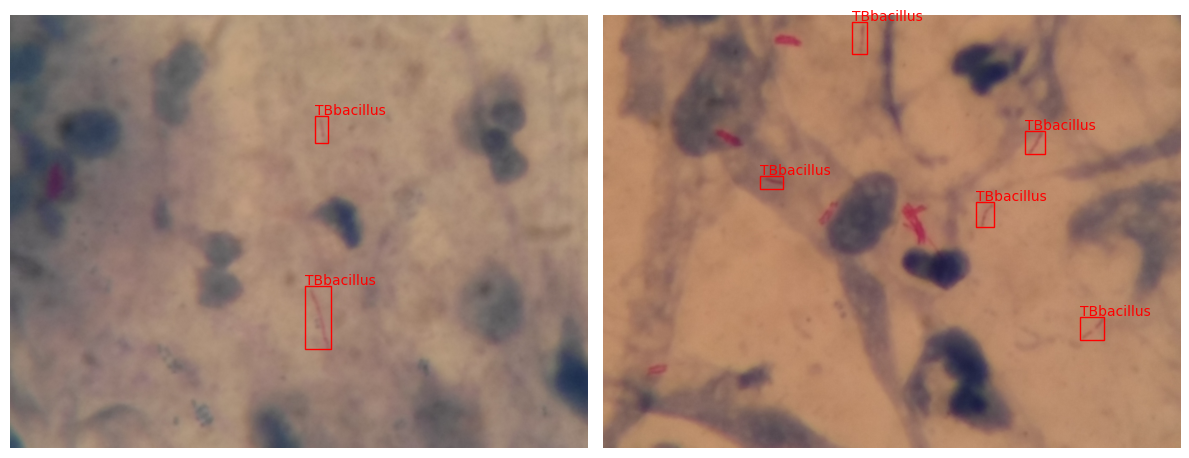

In [167]:
# show some of the images in the dataset with their GT annotations
for batch in tr_dataloader:
    images, targets = batch
    fig, axes = plt.subplots(1, len(images), figsize=(12, 6))
    for i, (im, target) in enumerate(zip(images, targets)):
        img = tr_dataset._images[target['image_id']].pil()
        target['boxes'] = tr_dataset.unnormalize_boxes(target['boxes'], img.size)
        # img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
        axes[i].imshow(np.array(img))
        for label, (x1, y1, x2, y2) in zip(target['labels'],target['boxes']):
            axes[i].add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='r'))
            axes[i].text(x1, y1-5, tr_dataset.id2label[label.item()], color='r')
        axes[i].axis('off');
    fig.tight_layout()
    break

Now train the model

In [ ]:
checkpoint_to_resume_from = "detr-r50_no-class-head.pth"
num_epochs = 15
# checkpoint_to_resume_from = "outputs/checkpoint.pth" 
dilation = True
# dilation makes the model more robust to small objects, but makes training slower (~2x higher training time)
# The memory footprint of a dilated model is also higher (~2x)

!cd bacili_detection/detr && python main.py \
    --dataset_file "bacilli_detection" \
        --image_dir "/Users/simon/Documents/Projects/TFM" \
        --output_dir "outputs-dcn" \
        --resume $checkpoint_to_resume_from \
        --logging_file "train.log" \
        --epochs $num_epochs \
        --num_classes 2 \
        --batch_size 2 \
        --device "mps" \
        --dilation

Now that the model was trained on our dataset, let's see how it does now with one of the images from the dataset.

In [5]:
# load the model from checkpoint
checkpoint_path = 'bacili_detection/detr/outputs/checkpoint.pth'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
model_trained = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=False, num_classes=2)
model_trained.load_state_dict(checkpoint['model'])
print("checkpoint loaded at epoch", checkpoint['epoch'])
model_trained.eval();

Using cache found in /Users/simon/.cache/torch/hub/facebookresearch_detr_main
/opt/homebrew/Caskroom/miniforge/base/envs/tf-env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


checkpoint loaded at epoch 14


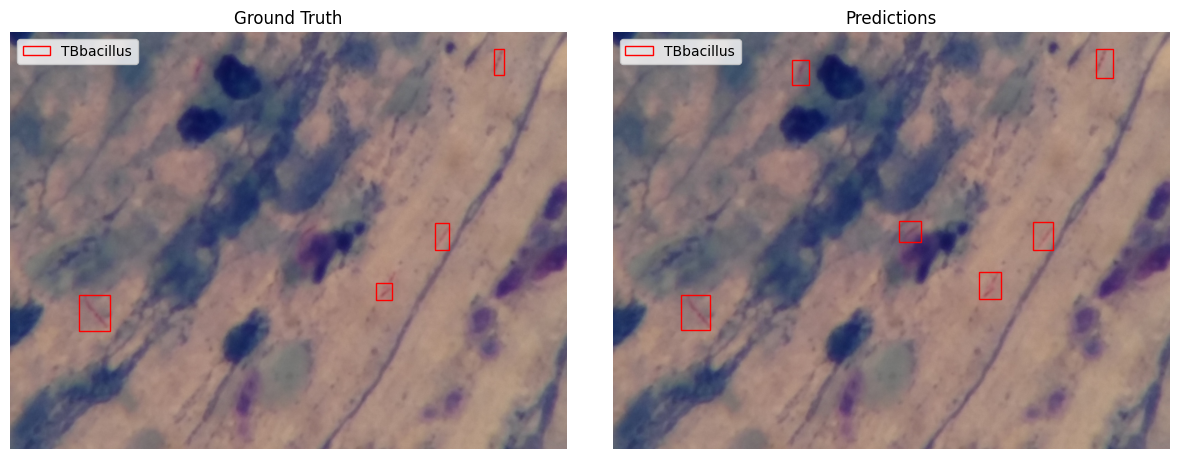

In [12]:
from bacili_detection.detr.models import detr_inference
from bacili_detection.utils import merge_rects
# Check with one of the images in the test dataset (which was not used for training)
test_dataset = TBBacilliDataset(['test'], transform=None)
imod = test_dataset._images[2]
# imod = tr_dataset._images[target['image_id']]
bboxes, labels = detr_inference([imod.pil()], model_trained, transform, dataset.id2label, threshold=0.95)
# plot both the GT and the predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
imod.display(ax=axes[0])
axes[0].set(title="Ground Truth")
axes[1].imshow(imod.numpy())
axes[1].set(title="Predictions")
for i, (label, (x1, y1, x2, y2)) in enumerate(zip(labels[0],bboxes[0])):
    axes[1].add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='r', label=label if i==0 else None))
    # axes[1].text(x1, y1-5, label, color='r')
axes[1].legend()
axes[1].axis('off');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


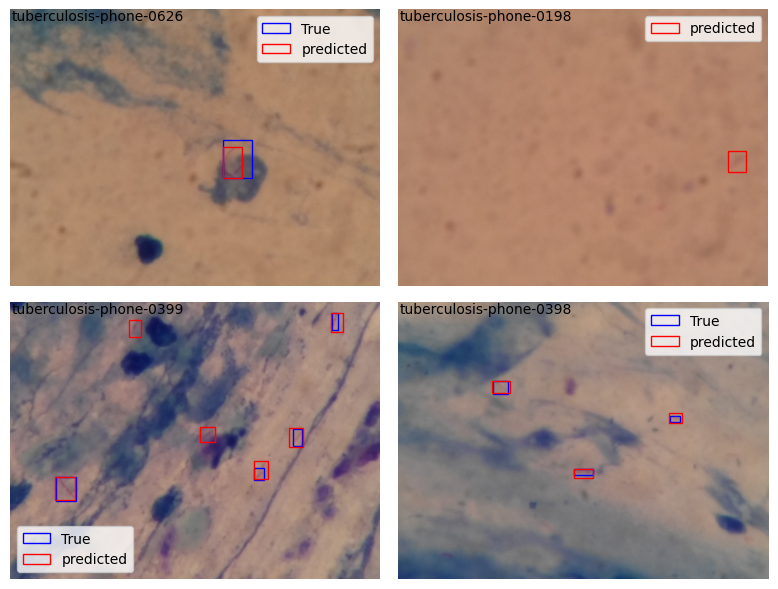

In [33]:
# inference on various images
images = test_dataset._images[:4]
imgs = [im.pil() for im in images]
bboxes = detr_inference(imgs, model_trained, transform, id2label, threshold=0.95, labels=False)
label = "predicted"
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for ax, img, boxes in zip(axes.flat,images, bboxes):
    img.display(ax=ax, color='blue', label='True')
    # ax.imshow(img.numpy())
    merged_boxes = merge_rects(boxes, buffer=1)
    for i, (x1, y1, x2, y2) in enumerate(merged_boxes):
        ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='r', label=label if i==0 else None))
        # ax.text(x1, y1-5, label, color='r')
    ax.text(5, 50, img.name, color='black')
    ax.legend()
    ax.axis('off');
fig.tight_layout()

That's much better :)

Metrics: IoU, mAP, mAR

In [44]:
from bacili_detection.utils.evaluate import evaluate
from functools import partial
import pandas as pd


detr_inference_func = partial(detr_inference, model=model_trained, transform=transform, id2label=id2label, threshold=0.95, labels=False)

# calculate the IoU between the predicted and the GT boxes
# as well as the precision and recall for each image
metrics = evaluate(test_dataset, detr_inference_func, batch_size=4)
pd.DataFrame(metrics).describe()

100%|██████████| 17/17 [00:45<00:00,  2.66s/it]


precision     recall        iou
count  66.000000  66.000000  66.000000
mean    0.873526   0.799133   0.568212
std     0.228529   0.264499   0.198848
min     0.000000   0.000000   0.000000
25%     0.833333   0.666667   0.460930
50%     1.000000   0.898990   0.569037
75%     1.000000   1.000000   0.707420
max     1.000000   1.000000   1.000000

Compare with baseline:

In [13]:
# now do the same for the other model
import sys
sys.path.append("ml-models/")
from sputum_detector.sputum_detection_model import SputumDetectionModel
from keras.models import load_model
model_keras = load_model('ml-models/sputum_detector/models/rcnn_MNasNet_2.h5')
modelobac = SputumDetectionModel(model_keras)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-09-03 16:56:55.110894: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-03 16:56:55.111150: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
from tqdm.notebook import tqdm
from bacili_detection.utils.misc import tile_coords

In [51]:
img_cuts = []
img_coords = []
imindex = []
w, h = test_dataset._images[0].pil().size
coords, _, _ = tile_coords(w,h, 80, 40)

for i in tqdm(range(0,len(test_dataset._images),4)):
    batch = test_dataset._images[i:i+4]
    batch = [im.pil() for im in batch]
    img_cuts = [
        np.array(im)[y1:y2, x1:x2]/255 
        for im in batch for x1, y1, x2, y2 in coords
    ]
    imindexes = [j for j in range(i,i+4) for _ in range(len(coords))]
    img_coords = img_coords + coords.tolist()
    out = model_keras.predict(np.array(img_cuts))
    rects = img_coords[out[:,0]>0.5]
    break

  0%|          | 0/17 [00:00<?, ?it/s]

2023-09-03 17:14:35.982795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


159/159 [==============================] - 17s 84ms/step


plot_utils.py::plot_logs info: logs param expects a list argument, converted to list[Path].


/Users/simon/Documents/Projects/TFM/bacili_detection/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/Users/simon/Documents/Projects/TFM/bacili_detection/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


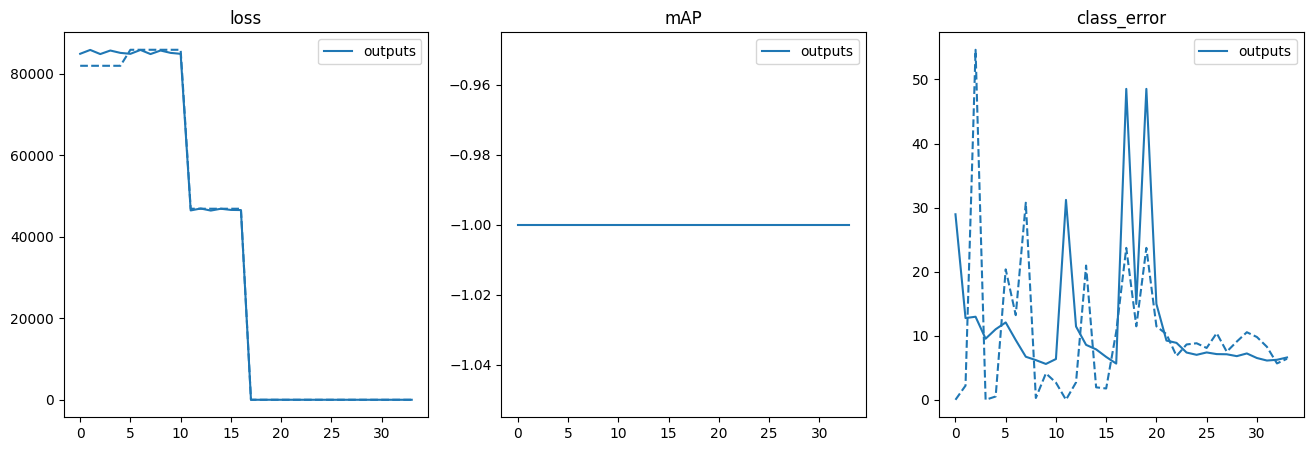

In [275]:
# training logs
from bacili_detection.detr.util.plot_utils import plot_logs
from pathlib import Path

plot_logs(Path('bacili_detection/detr/outputs/'), ['loss', 'mAP', 'class_error'])

In [ ]:
# from bacili_detection.detr.util.box_ops import box_cxcywh_to_xyxy
# import cv2

# img, target = ds[0]
# display(target)
# print("previous h/w ratio:", target['size'][0]/target['size'][1])
# new_img, new_target = transforms(*ds[0])
# # resize new image to original size
# new_img = cv2.resize(new_img.numpy().transpose(1,2,0), tuple(target['orig_size'].numpy()))
# display(new_target)
# print("new h/w ratio:", new_target['size'][0]/new_target['size'][1])
# boxes = new_target['boxes']
# x_c, y_c, w, h = boxes.unbind(1)
# height, width = new_target['orig_size']
# b_xyxy = [(x_c - 0.5 * w), (y_c - 0.5 * h),
#          (x_c + 0.5 * w), (y_c + 0.5 * h)]
# display(torch.stack(b_xyxy, dim=-1))
# s = torch.tensor([width, height, width, height])
# boxes = (torch.stack(b_xyxy, dim=-1) * s).numpy().astype(np.int16)
# display(boxes)
# new_img = ((new_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255).astype(np.uint8)
# plt.imshow(new_img.transpose(1,0,2))
# # plt.imshow(img)
# for label, (x1, y1, x2, y2) in zip(new_target['labels'], boxes):
#     plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='r'))
#     plt.text(x1, y1-5, ds.id2label[label.numpy().item()], color='r')

# for label, (x1, y1, x2, y2) in zip(target['labels'], target['boxes']):
#     plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='b'))
#     plt.text(x1, y1-5, ds.id2label[label.numpy().item()], color='b')